In [1]:
import os
import pickle
import cv2
import numpy as np
import math
import time

%matplotlib inline
import matplotlib.pyplot as plt
import ipywidgets.widgets as widgets
from IPython.display import display

import shapely.geometry
import shapely.ops

In [138]:
landmarks = [
    {
    "label": 19,
    "obj_name": 'horse',
    "width": 0.394,
    "observed": False,
    "actual_x": 1.50,
    "actual_y": 1.50,
    "Mu": [],
    "blocked": [[1.3,1.56],[1.7,1.44]],    
    "barrier": np.array([[1.3,1.44],
                    [1.3,1.56],
                    [1.5,1.56],
                    [1.7,1.56],
                    [1.7,1.44],
                    [1.5,1.44]
                   ])
    },
    {
    "label": 44,
    "obj_name": 'bottle',
    "width": 0.10,
    "observed": False,
    "actual_x": 0.75,
    "actual_y": 1.50,
    "Mu": [],
    "blocked": [[0.7,1.55],[0.8,1.45]],    
    "barrier": np.array([[0.8,1.55],
                    [0.8,1.45],
                    [0.7,1.45],
                    [0.7,1.55]
                   ])
    },
    {
    "label": 63,
    "obj_name": 'couch',
    "width": 1.68,
    "observed": False,
    "actual_x": -0.50,
    "actual_y": 1.21,
    "Mu": [],
    "blocked": [[-1.45,2.18],[-0.25,0.5]],    
    "barrier": np.array([[-1.45,2.18],
                    [-0.25,2.18],
                    [-0.25,1.34],
                    [-0.25,0.5],
                    [-1.45,0.5],
                    [-1.45,1.34]
                   ])
    },
    {
    "label": 72,
    "obj_name": 'TV',
    "width": 1.00,
    "observed": False,
    "actual_x": 2.0,
    "actual_y": 0.9,
    "Mu": [],
    "blocked": [[1.9,1.5],[2.5,0.25]],    
    "barrier": np.array([[1.9,1.5],
                    [2.5,1.5],
                    [2.5,0.9],
                    [2.5,0.25],
                    [1.9,0.25],
                    [1.9,0.9]
                   ])
    },
    {
    "label": 64,
    "obj_name": 'potted plant',
    "width": 0.55,
    "observed": False,
    "actual_x": 0.5,
    "actual_y": -0.10,
    "Mu": [],
    "blocked": [[0.2,0.1],[0.8,-0.3]],    
    "barrier": np.array([[0.2,0.1],
                    [0.8,0.1],
                    [0.8,-0.3],
                    [0.2,-0.3]
                   ])
    }
]

barrier = np.array([[0.5,0.5],
                    [0.5,0.75],
                    [0.5,1.0],
                    [0.75,1.0],
                    [1.0,1.0],
                    [1.0,0.75],
                    [1.0,0.5],
                    [0.75,0.5]
                   ])

blocked = [[0.5,1.0],[1.0,0.5]]

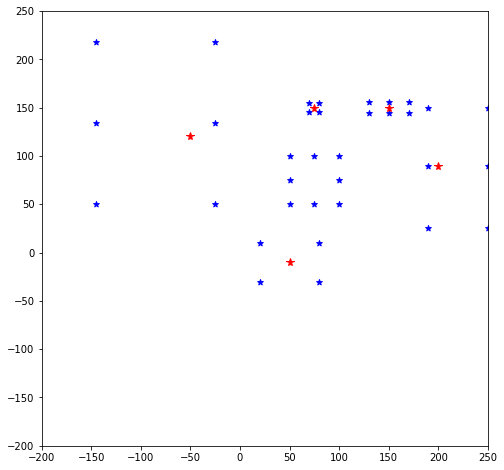

In [139]:
""" Update robot position on map """
plt.figure(figsize=(8,8))
plt.xlim([-200,250])
plt.ylim([-200,250])

    
""" Display landmark as green cross, uncorrected landmark as lime cross """
for i, landmark in enumerate(landmarks):
    # Mark landmark's actual locations
    landmark_x_actual = landmark["actual_x"]*100
    landmark_y_actual = landmark["actual_y"]*100
    plt.plot(landmark_x_actual, landmark_y_actual, marker='*', markersize=8, color='red')
    
    if landmark["blocked"] is not None:
        plt.scatter(landmark["barrier"][:,0]*100, landmark["barrier"][:,1]*100, marker='*', color='blue') 
    
""" Display central barrier """
plt.scatter(barrier[:,0]*100, barrier[:,1]*100, marker='*', color='blue')     

plt.show()
plt.close()

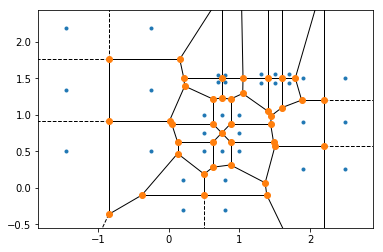

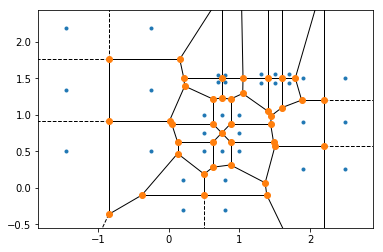

In [140]:
from scipy.spatial import Voronoi, voronoi_plot_2d

num_pt = 0
for landmark in landmarks:
        landmark_barrier = landmark["barrier"]
        num, _ = landmark_barrier.shape
        num_pt += num
        
num, _ = barrier.shape
num_pt += num
points = np.zeros((num_pt,2))

# create landmark points
j = 0
for landmark in landmarks:
        landmark_barrier = landmark["barrier"]
        num, _ = landmark_barrier.shape
        for i in range(num):
            points[j,0] = landmark_barrier[i,0]
            points[j,1] = landmark_barrier[i,1]
            j += 1
    
# create barrier points
num, _ = barrier.shape
for i in range(num):
    points[j,0] = barrier[i,0]
    points[j,1] = barrier[i,1]    
    j += 1
    
vor = Voronoi(points)
voronoi_plot_2d(vor)

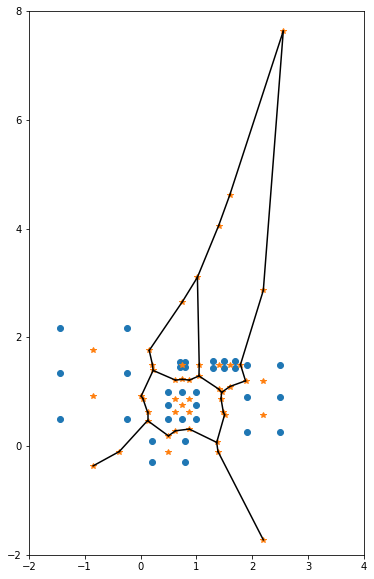

In [169]:
def in_blocked_area(blocked, point):
    """ Check if a point falls within a blocked region """
    x,y = point
    ULeft_x, ULeft_y = blocked[0]
    LRight_x, LRight_y = blocked[1]
    
    if (ULeft_x<=x<=LRight_x) and (ULeft_y>=y>=LRight_y):
        return True
    else:
        return False
    
def valid_point(blocked_areas ,point):
    """ A point is valid if it does not wihin a list of blocked regions """
    for area in blocked_areas:
        if in_blocked_area(area, point):
            return False

    return True

blocked_areas = []
blocked_areas.append(blocked)
for landmark in landmarks:
        blocked_areas.append(landmark["blocked"])

plt.figure(figsize=(6,10))    
plt.plot(points[:, 0], points[:, 1], 'o')
plt.plot(vor.vertices[:, 0], vor.vertices[:, 1], '*')
plt.xlim(-2, 4); plt.ylim(-2, 8)

i = 0
for simplex in vor.ridge_vertices:
    simplex = np.asarray(simplex)
    x = vor.vertices[simplex, 0]  
    y = vor.vertices[simplex, 1]
    start = vor.vertices[simplex[0]] 
    end = vor.vertices[simplex[1]]
    
    if np.all(simplex >= 0) and (valid_point(blocked_areas,start) and valid_point(blocked_areas,end)):
        plt.plot(x,y,'k-', color="black")

    # print(simplex)
    # print ("start {}, end{}".format(start,end))
    # print ("{},{}".format(in_blocked_area(blocked, start),in_blocked_area(blocked, end)))
        
    i += 1
